### Cardiac Arrhythmia Multy-Class Classification 

Analyze data and address missing data if there is any. 

Decide aboute a good evaluation strategy and justify your choice. 

Find the best parameters for the following classification models: 
- KNN classifcation 
- Logistic Regression
- Linear Supprt Vector Machine
- Kerenilzed Support Vector Machine
- Decision Tree
- Random Forest 

Then use different bagging and boosting methods to boost the results? Do you see any significant change? Why or why not? 

Next, use data reduction method you have learned in class to reduce the size of data, and agian try above models. Do you get better results? Justify your answer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the data 
df = pd.read_csv('Project_2.csv')
df.head()

,Age,Sex,Height,Weight,QRSduration,P-Rinterval,Q-Tinterval,Tinterval,Pinterval,VectorAnglesQRS,...,V6AmplitudeQwave,V6AmplitudeRwave,V6AmplitudeSwave,V6AmplitudeR'wave,V6AmplitudeS'wave,V6AmplitudePwave,V6AmplitudeTwave,V6AmplitudeQRSA,V6AmplitudeQRSTA,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [3]:
# checking for missing values. 
df.isnull().sum().max()

0

In [4]:
# the above doesn't show Missing values however, missing values are marked as ? 
# hence we replaced ? to Null values
df = df.replace('?',np.NaN)

In [5]:
# Checking percentage of missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (total/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.sort_values('Percent',ascending=False).head(8)

,Total,Percent
VectorAnglesJ,376,0.831858
VectorAnglesP,22,0.048673
VectorAnglesT,8,0.017699
Heart Rate,1,0.002212
VectorAnglesQRST,1,0.002212
V2Rwave,0,0.000000
V3AmplitudeQRSTA,0,0.000000
V3AmplitudeQRSA,0,0.000000


We can observe that VectorAnglesJ has almost 83% missing data everything else is less than 5%.
Lets chart VectorAnglesP and VectorAnglesT and check if there are in outliers in the data. 

In [6]:
print("median of VectorAnglesT : "+str(df['VectorAnglesT'].median()))
print("median of VectorAnglesP : "+str(df['VectorAnglesP'].median()))
print("median of Heart Rate : "+str(df['Heart Rate'].median()))
print("median of Heart Rate : "+str(df['VectorAnglesQRST'].median()))

median of VectorAnglesT : 41.0
median of VectorAnglesP : 56.0
median of Heart Rate : 72.0
median of Heart Rate : 40.0


In [7]:
df['VectorAnglesJ'].sort_values(ascending=False).head(20)

334     91
285     86
112     84
8       84
449     84
324     74
404     62
138     36
297     33
2       23
187    178
89     177
388    176
99     175
254    169
202    169
235    164
189    161
29     160
71     154
Name: VectorAnglesJ, dtype: object

Now, we can observe that there are negative values in VectorAnglesT and VectoranglesP.
To keep things easy we will just handle the missing values with medians instead of means as it will not be affected by outliers and negative value. 
Also, the values in the vectorAngleJ are distrubited across and hence with almost 83% data missing its better to drop this column when making predictions.

In [8]:
df = df.drop(missing_data[missing_data['Total']>50].index,axis=1)

In [9]:
#filling the data with median values
df = df.fillna(df.median())

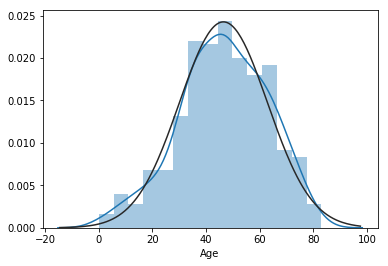

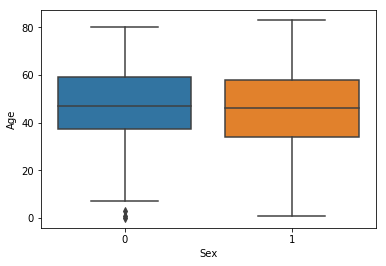

In [10]:
#checking the the distribution of type of patients
from scipy.stats import norm
sns.distplot(df['Age'], fit=norm);
plt.show()
sns.boxplot(df['Sex'],df['Age']) # 0 is male and 1 is female
plt.show()

We can observe that the patients age is evenly distriuted and end its similar for both male and female category.

In [11]:
# checking the class count for the dataset 
df.groupby('Class')['Age'].count()

Class
1     245
2      44
3      15
4      15
5      13
6      25
7       3
8       2
9       9
10     50
14      4
15      5
16     22
Name: Age, dtype: int64

There is no Class 11,12,13 data. We have confirmed that above.

      Class code :   Class   :                       Number of instances:
       01             Normal				                      245
       02             Ischemic changes (Coronary Artery Disease)   44
       03             Old Anterior Myocardial Infarction           15
       04             Old Inferior Myocardial Infarction           15
       05             Sinus tachycardy			                 13
       06             Sinus bradycardy			                 25
       07             Ventricular Premature Contraction (PVC)       3
       08             Supraventricular Premature Contraction	    2
       09             Left bundle branch block 		             9	
       10             Right bundle branch block		            50
       11             1. degree AtrioVentricular block	          0	
       12             2. degree AV block		                    0
       13             3. degree AV block		                    0
       14             Left ventricule hypertrophy 	              4
       15             Atrial Fibrillation or Flutter	            5
       16             Others				                       22



In [12]:
df[['Class']] = df[['Class']].replace([7, 8, 9,14,15], [17, 17, 17,17,17])
df.groupby('Class')['Age'].count()

Class
1     245
2      44
3      15
4      15
5      13
6      25
10     50
16     22
17     23
Name: Age, dtype: int64

#### We have replaced the less frequent classes in our dataset to a new class called 17.



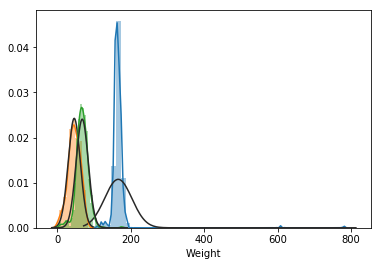

In [14]:
sns.distplot(df['Height'],fit=norm)# 0 is male and 1 is female
sns.distplot(df['Age'],fit=norm)
sns.distplot(df['Weight'],fit=norm)
#sns.distplot(df['P-Rinterval'],fit=norm)
plt.show()

In [15]:
cm_dark = ListedColormap(['#ff6060', '#8282ff','#ffaa00','#fff244','#4df9b9','#76e8fc',
                          '#3ad628','#c13b01','#0d632d','#0c1163','#4a0c63','#630c24',
                          '#0c5863','#c3db0f','#1b4956'])
cm_bright = ListedColormap(['#ffafaf', '#c6c6ff','#ffaa00','#ffe2a8','#bfffe7','#c9f7ff','#9eff93'])
cm_bright2 = ListedColormap(['#ff9696', '#c3c3f7','#ffc05b','#fffda0','#90e5c6','#eafbff',
                          '#10a300','#ffcdb7','#49bc74','#d1d3ff','#f3d6ff','#ffbcce',
                          '#b7f5ff','#ffd079','#b2ffcf'])

We can observe that there are couple of outliers in our data, which we will need to handle during classification later.But its good that we know that these outliers exists as it can be a problem during classification. 

For understanding the waves in our classification data set, I have downloaded the image to understand what each wave looks like. 

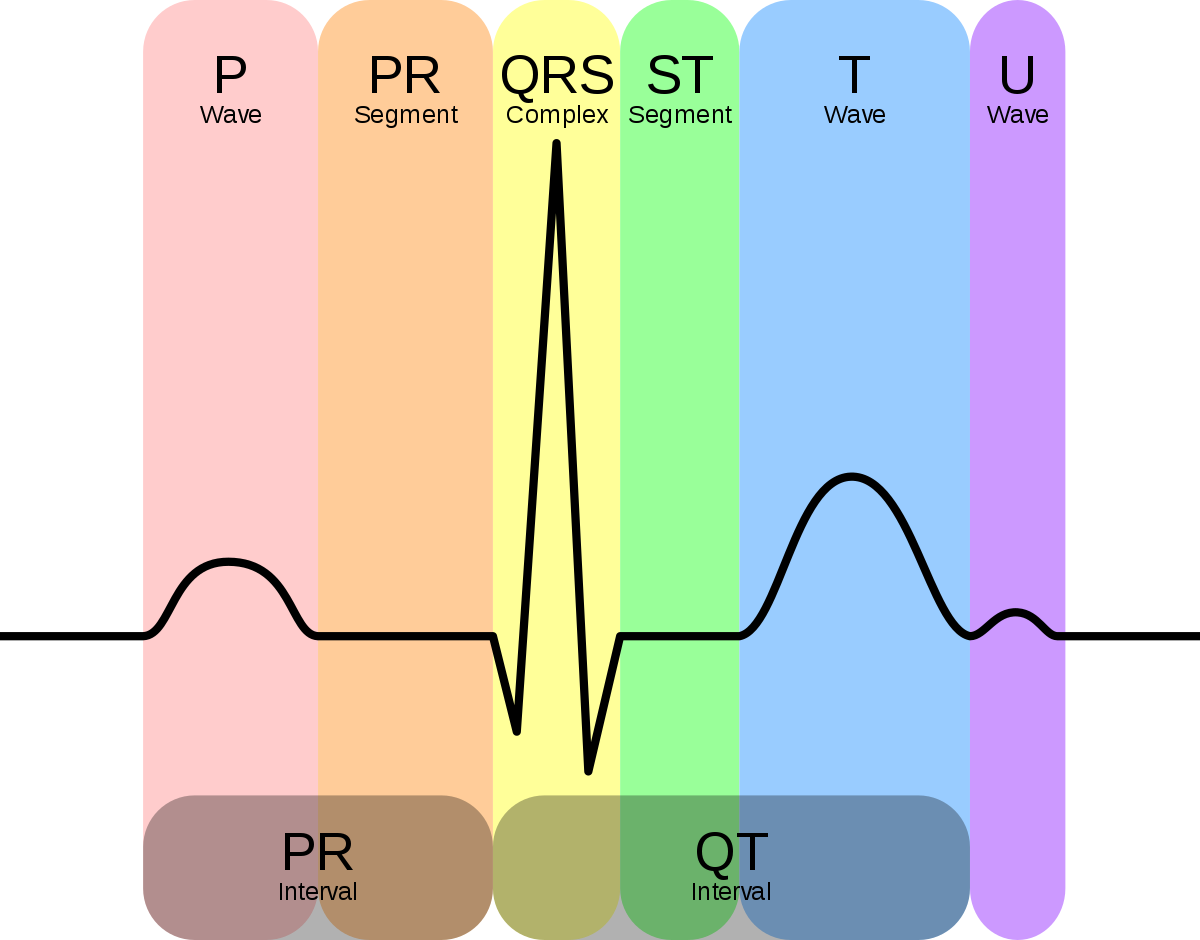

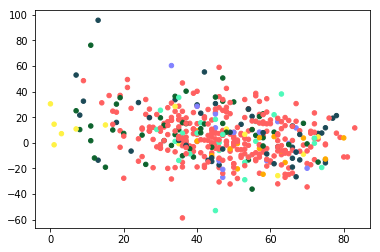

In [16]:
plt.scatter(x=df['Age'],y=df['DIIIAmplitudeQRSTA'],c=df['Class'],cmap=cm_dark,s=20,label=df['Class'])
#plt.scatter(X[:,12], X[:,0],c=Y,cmap=cm_dark, marker= 'o', s=50,label=Y)
plt.show()

After multiple scatterplot check we can see that in 2D we cannot really a good distribution of classes across the plane.Hence we will now try to plot in 3D to see some specific distrbution across the 3D plane. 

Since we have so many variables, we have the curse of dimensionality and hence we may not be able to see the real relation visually. Never the less lets try the 3D plot.

<IPython.core.display.Javascript object>


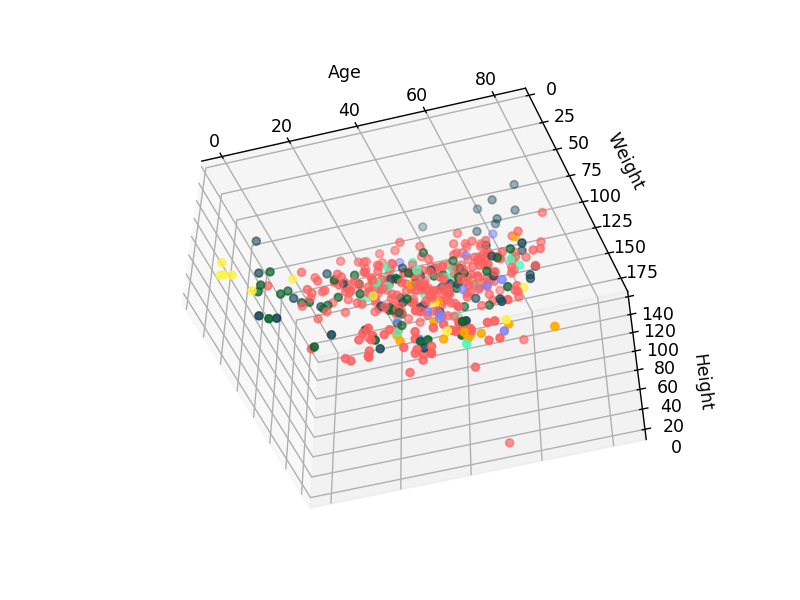

In [17]:
# plotting a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df['Age'],df['Weight'],df['AVRQwave'],c = df['Class'],cmap=cm_dark, s=20)
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Height')
plt.show()

We can observe from the 3D scatter plot that there are some classes that can be visibly seen together, whereas several are not together but across the 3d plane.Thus, one of our assumption is that if there we could observe more than 3 dimensions then we could have observed more clearly. Never the less, its important for us to think about our data set with this perspective.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# creating X and y data set
y = df['Class']
X = df
X = df.drop(['Class'],axis=1)

X_train_org, X_test_org, y_train, y_test = train_test_split(X,y, test_size = 0.05, random_state = 10)
print("Shape of X Train : "+str(X_train_org.shape))
print("Shape of Y Train : "+str(y_train.shape))
print("Shape of X Test : "+str(X_test_org.shape))
print("Shape of Y Test : "+str(y_test.shape))
sc = MinMaxScaler()
X_train_org = sc.fit_transform(X_train_org)
X_test_org = sc.fit_transform(X_test_org)

Shape of X Train : (429, 278)
Shape of Y Train : (429,)
Shape of X Test : (23, 278)
Shape of Y Test : (23,)


## KNN classifcation


So we did run the below grid search which took ages to calculate :

- param_grid = {'n_neighbors':[3,5, 10, 20, 50]}

- The best parameter for the same came out too be {'n_neighbors': 3}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [19]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report

# Using KNN to classify the glasses 
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train_org,y_train)
accuracy = knn.score(X_train_org,y_train)
print("The accuracy of the KNN Classifier is :"+str(accuracy))
pred = knn.predict(X_test_org)
print(classification_report(y_test,pred))

# Recycled code
# param_grid = {'n_neighbors':[3,5, 10, 20, 50]}
# conf_mat = confusion_matrix(y_test,pred)
# cm = pd.DataFrame(conf_mat,range(8),range(8))
# cm
# print("{} = best paramaters \n".format(knn.best_params_))

The accuracy of the KNN Classifier is :0.680652680653
             precision    recall  f1-score   support

          1       0.75      1.00      0.86        12
          2       0.00      0.00      0.00         2
          3       1.00      1.00      1.00         2
          4       0.50      1.00      0.67         1
          6       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.50      1.00      0.67         1

avg / total       0.52      0.70      0.59        23



<IPython.core.display.Javascript object>


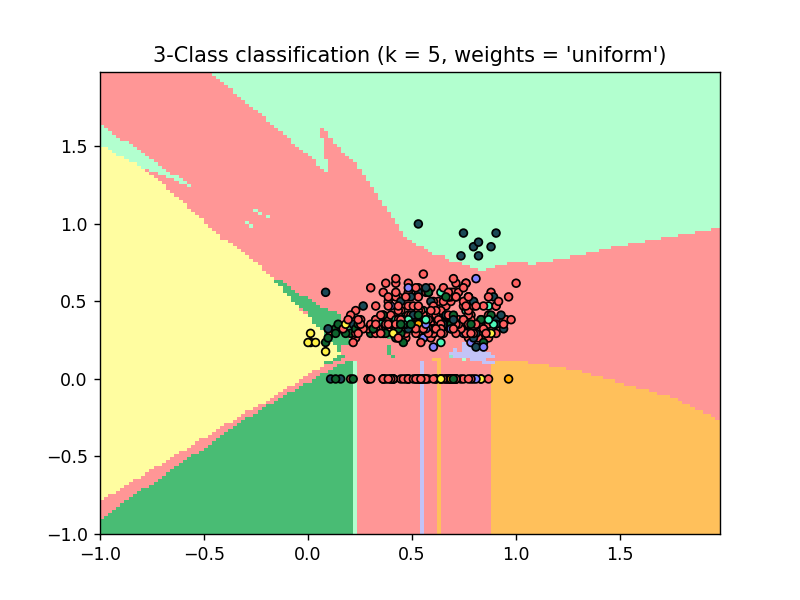

<IPython.core.display.Javascript object>


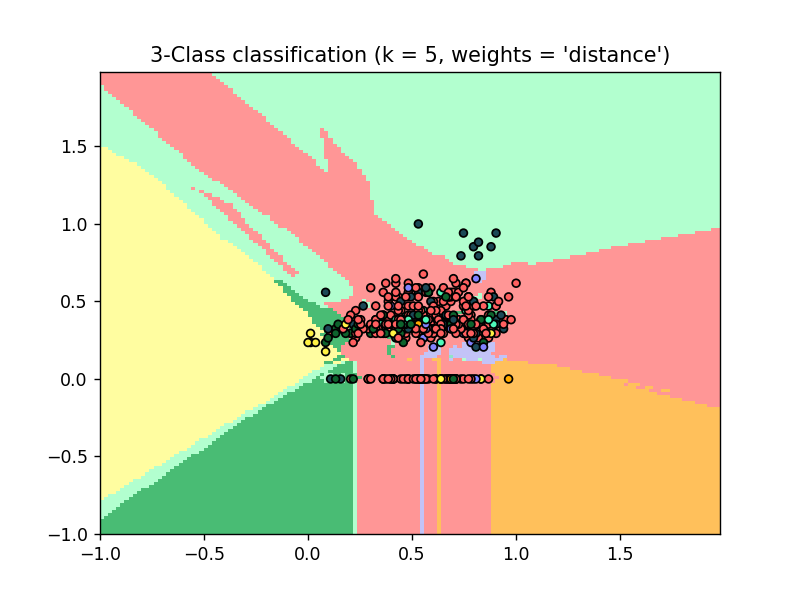

In [20]:
# plotting the decision boundries for the data 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

# note : decision boundry is 2D ! hence 2D features only ! 

X = df.as_matrix(['Age','AVRQwave'])
X = sc.fit_transform(X)
y = np.array(df['Class'])

h = .02  # step size in the mesh
n_neighbors = 5 # No of neighbours
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   # ravel to flatten the into 1D and c_ to concatenate 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cm_bright2)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"% (n_neighbors, weights))

plt.show()

PCA  - minmax scaling is important because if we don not do Minmax scaling or any kind of scaling then the pca will make the variation between 0 and 1 and then it might choose an incorrect first variable. 

## Logistic Regression

So we did run the below grid search which took ages to calculate :

- param_grid ={'penalty': [l1','l2']}

- The best parameter for the same came out too be {'penalty': 'l2'}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [21]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(penalty='l2').fit(X_train_org, y_train)
print("The logistic regression accuracy score for training set is : "+str(logR.score(X_train_org,y_train)))
print("The logistic regression accuracy score for test set is : "+str(logR.score(X_test_org,y_test)))
logR_pred = logR.predict(X_test_org)
conf_mat = confusion_matrix(y_test,logR_pred)
print(classification_report(y_test,logR_pred))

# Recycled code : 
# param_grid = {'penalty':['l1','l2']}
# print("{} =  best parameters ".format(logR.best_params_)+"\n")

The logistic regression accuracy score for training set is : 0.792540792541
The logistic regression accuracy score for test set is : 0.782608695652
             precision    recall  f1-score   support

          1       0.83      0.83      0.83        12
          2       1.00      0.50      0.67         2
          3       1.00      1.00      1.00         2
          4       0.50      1.00      0.67         1
         10       0.60      1.00      0.75         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.75      0.78      0.75        23



<IPython.core.display.Javascript object>


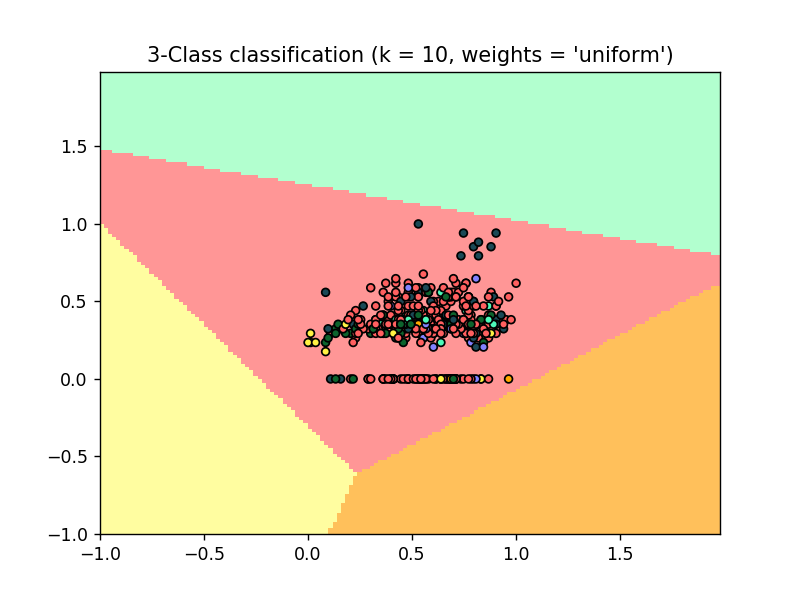

<IPython.core.display.Javascript object>


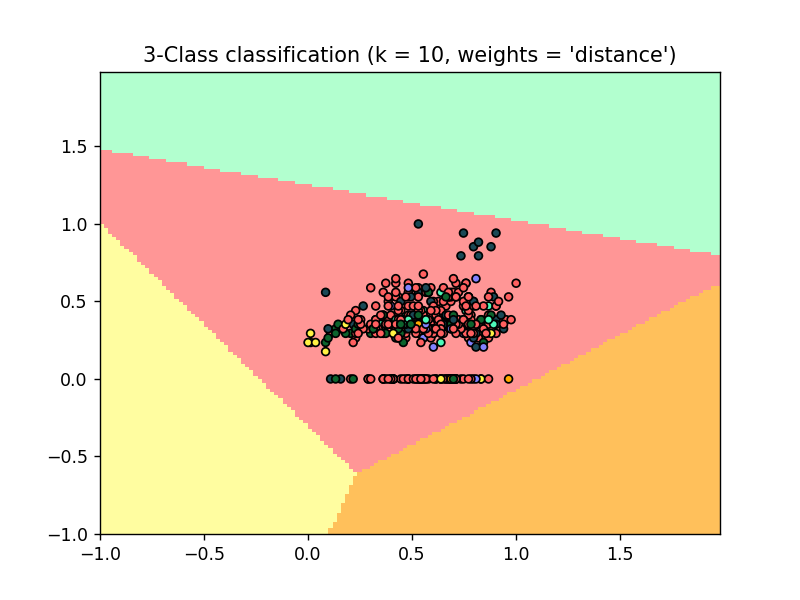

In [22]:
# plotting the decision boundries for the data 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

# note : decision boundry is 2D ! hence 2D features only ! 

X = df.as_matrix(['Age','AVRQwave'])
X = sc.fit_transform(X)
y = np.array(df['Class'])

h = .02  # step size in the mesh
n_neighbors = 10 # No of neighbours
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = LogisticRegression(C=20)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   # ravel to flatten the into 1D and c_ to concatenate 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cm_bright2)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"% (n_neighbors, weights))

plt.show()

### LINEAR SVM CLASSIFIER 

So we did run the below grid search which took ages to calculate :

- param_grid ={'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

- The best parameter for the same came out too be {'C': 1, 'gamma': 0.001}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear',C=1,gamma=.001,random_state=10).fit(X_train_org,y_train)
print("The svm linear accuracy score for training set is : "+str(svm.score(X_train_org,y_train)))
print("The svm linear accuracy score for test set is : "+str(svm.score(X_test_org,y_test)))
svm_pred = svm.predict(X_test_org)
conf_mat = confusion_matrix(y_test,svm_pred)
print(classification_report(y_test,svm_pred))

# Recycled code : 
# print("The best paramteters are :"+str(svm.best_params_))

The svm linear accuracy score for training set is : 0.890442890443
The svm linear accuracy score for test set is : 0.652173913043
             precision    recall  f1-score   support

          1       0.89      0.67      0.76        12
          2       0.25      0.50      0.33         2
          3       0.67      1.00      0.80         2
          4       0.50      1.00      0.67         1
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
         10       1.00      1.00      1.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.70      0.65      0.66        23



## NON LINEAR(RBF) SVM CLASSIFER 

So we did run the below grid search which took ages to calculate :

- param_grid ={'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

- The best parameter for the same came out too be {'C': 10, 'gamma': 0.1}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [24]:
svm_rbf = SVC(kernel = 'rbf',C=10,gamma=0.1,random_state = 10).fit(X_train_org,y_train)
print("The svm non-linear accuracy score for training set is : "+str(svm_rbf.score(X_train_org,y_train)))
print("The svm non-linear accuracy score for test set is : "+str(svm_rbf.score(X_test_org,y_test)))
svm_rbf_pred = svm_rbf.predict(X_test_org)
conf_mat = confusion_matrix(y_test,svm_rbf_pred)
print(classification_report(y_test,svm_rbf_pred))

The svm non-linear accuracy score for training set is : 0.972027972028
The svm non-linear accuracy score for test set is : 0.0869565217391
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        12
          2       0.00      0.00      0.00         2
          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         1
         10       0.25      0.33      0.29         3
         16       0.00      0.00      0.00         2
         17       0.07      1.00      0.12         1

avg / total       0.04      0.09      0.04        23



## DECISION TREES

So we did run the below grid search which took ages to calculate :

- param_grid = {'max_depth': [2,3,5,10, 20, 50, 100]}

- The best parameter for the same came out too be {'max_depth': 10}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [25]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=10,random_state=23).fit(X_train_org,y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(dtc.score(X_train_org, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(dtc.score(X_test_org, y_test)))
dtc_pred = dtc.predict(X_test_org)
conf_mat = confusion_matrix(y_test,dtc_pred)
print(classification_report(y_test,dtc_pred))

# Recycled Code
# param_grid = {'max_depth': [2,3,5,10, 20, 50, 100]}
# print('{} = best parameters'.format(dtc.best_params_))

Accuracy of Decision Tree classifier on training set: 0.95
Accuracy of Decision Tree classifier on test set: 0.30
             precision    recall  f1-score   support

          1       0.33      0.17      0.22        12
          2       1.00      0.50      0.67         2
          3       0.00      0.00      0.00         2
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
         10       0.20      0.67      0.31         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.37      0.30      0.30        23



## RANDOM FOREST

So we did run the below grid search which took ages to calculate :

- param_grid = {'max_depth' : [5,10,20,30,50,100],'n_estimators' : [100,200,300,400,500,600],'max_features':[50,100,200]}

- The best parameters for the same came out too be {'max_depth': 30, 'max_features': 200, 'n_estimators': 600}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [26]:
from sklearn.ensemble import RandomForestClassifier

#param_grid = {'max_depth' : [5,10,20,30,50,100],'n_estimators' : [100,200,300,400,500,600],'max_features':[50,100,200]}
forest_model = RandomForestClassifier(max_depth = 30, n_estimators=600,max_features=200,oob_score=True, n_jobs=-1, random_state=1234)
forest_model.fit(X_train_org, y_train)
fm_preds = forest_model.predict(X_test_org)
print("R2 score from training set :"+str(forest_model.score(X_train_org,y_train)))
print("R2 score from test set :"+str(forest_model.score(X_test_org,y_test)))
#print("{} = best paramters }".format(forest_model.best_params_)
conf_mat = confusion_matrix(y_test,fm_preds)
conf_mat
print(classification_report(y_test,fm_preds))

R2 score from training set :1.0
R2 score from test set :0.565217391304
             precision    recall  f1-score   support

          1       1.00      0.33      0.50        12
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         2
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
         10       0.38      1.00      0.55         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.83      0.57      0.59        23



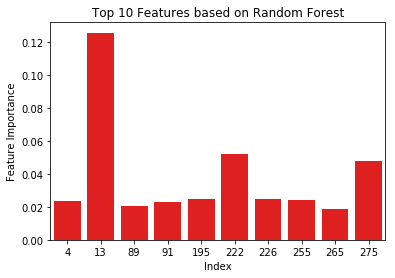

In [27]:
# Just checking feature importance for variables in 
feature_importance = pd.DataFrame(forest_model.feature_importances_,columns=['Feature Importance'])
feature_importance['Index'] = feature_importance.index
top10 = feature_importance.sort_values('Feature Importance',ascending=False).head(10)
%matplotlib inline
sns.barplot(x="Index", y="Feature Importance", data=top10,color='red')
plt.title('Top 10 Features based on Random Forest')
plt.show()

##### VectorAngleQRST is our 13th variable and shows up as the most important based on Random forest. 


### BAGGING AND PASTING TECHNIQUES 

Applying BAGGING And PASTING techniques on DecisionTreeClassifier.

In [28]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(DecisionTreeClassifier(random_state=10), n_estimators=500, max_samples=100, 
                        bootstrap=True, n_jobs=-1, random_state=10).fit(X_train_org, y_train)
bag_preds = bag.predict(X_test_org)
print("R2 score from training set :"+str(bag.score(X_train_org,y_train)))
print("R2 score from test set :"+str(bag.score(X_test_org,y_test)))
#print(oob_score_)
#print("RMSE from test set :"+str(np.sqrt(metrics.mean_squared_error(fm_preds,y_test))))
conf_mat = confusion_matrix(y_test,bag_preds)
conf_mat
print(classification_report(y_test,bag_preds))

R2 score from training set :0.83682983683
R2 score from test set :0.565217391304
             precision    recall  f1-score   support

          1       1.00      0.50      0.67        12
          2       0.50      1.00      0.67         2
          3       1.00      0.50      0.67         2
          4       0.00      0.00      0.00         1
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
         10       0.43      1.00      0.60         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.75      0.57      0.59        23



In [29]:
# Pasting !! 
pasting = BaggingClassifier(DecisionTreeClassifier(random_state=10), n_estimators=500, max_samples=100, 
                        bootstrap=False, n_jobs=-1, random_state=10).fit(X_train_org, y_train)
pasting_preds = bag.predict(X_test_org)
print("R2 score from training set :"+str(pasting.score(X_train_org,y_train)))
print("R2 score from test set :"+str(pasting.score(X_test_org,y_test)))
#print("RMSE from test set :"+str(np.sqrt(metrics.mean_squared_error(fm_preds,y_test))))
conf_mat = confusion_matrix(y_test,pasting_preds)
conf_mat
print(classification_report(y_test,pasting_preds))

R2 score from training set :0.86013986014
R2 score from test set :0.478260869565
             precision    recall  f1-score   support

          1       1.00      0.50      0.67        12
          2       0.50      1.00      0.67         2
          3       1.00      0.50      0.67         2
          4       0.00      0.00      0.00         1
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
         10       0.43      1.00      0.60         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.75      0.57      0.59        23



In [30]:
bag_logr = BaggingClassifier(LogisticRegression(penalty='l2'), n_estimators=500, max_samples=100, 
                        bootstrap=True, n_jobs=-1, random_state=10).fit(X_train_org, y_train)
bag_logr_preds = bag_logr.predict(X_test_org)
print("R2 score from training set :"+str(bag_logr.score(X_train_org,y_train)))
print("R2 score from test set :"+str(bag_logr.score(X_test_org,y_test)))
#print(oob_score_)
#print("RMSE from test set :"+str(np.sqrt(metrics.mean_squared_error(fm_preds,y_test))))
conf_mat = confusion_matrix(y_test,bag_logr_preds)
conf_mat
print(classification_report(y_test,bag_logr_preds))

R2 score from training set :0.636363636364
R2 score from test set :0.739130434783
             precision    recall  f1-score   support

          1       0.85      0.92      0.88        12
          2       0.50      0.50      0.50         2
          3       1.00      0.50      0.67         2
          4       0.50      1.00      0.67         1
         10       0.60      1.00      0.75         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.67      0.74      0.69        23



In [31]:
Pasting_logr = BaggingClassifier(LogisticRegression(penalty='l2'), n_estimators=500, max_samples=100, 
                        bootstrap=False, n_jobs=-1, random_state=10).fit(X_train_org, y_train)
pasting_logr_preds = Pasting_logr.predict(X_test_org)
print("R2 score from training set :"+str(Pasting_logr.score(X_train_org,y_train)))
print("R2 score from test set :"+str(Pasting_logr.score(X_test_org,y_test)))
#print(oob_score_)
#print("RMSE from test set :"+str(np.sqrt(metrics.mean_squared_error(fm_preds,y_test))))
conf_mat = confusion_matrix(y_test,pasting_logr_preds)
conf_mat
print(classification_report(y_test,pasting_logr_preds))

R2 score from training set :0.65034965035
R2 score from test set :0.739130434783
             precision    recall  f1-score   support

          1       0.85      0.92      0.88        12
          2       0.50      0.50      0.50         2
          3       1.00      0.50      0.67         2
          4       0.50      1.00      0.67         1
         10       0.60      1.00      0.75         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.67      0.74      0.69        23



### Gradient Boosting 

The difference between ADA boost and Gradient boost is that with GB we are trying to fit the  new predictors to the residuals made by previous predictor at each step , whereas with ADA Boost we are trying to fit the misclassified instances from the previous predictor with weight change to misclassified instances. 

Also, In ADA boost we will have to use a base Classifer it can be any algorithm of classifier. 

Gradient boosting involves three elements:

- A loss function to be optimized.
- A weak learner to make predictions.
- An additive model to add weak learners to minimize the loss function.

Note : Decision trees are used as the weak learner in gradient boosting. 

So we did run the below grid search which took ages to calculate :

- param_grid = {'learning_rate':[.05,.075,.01,.05,1,5],'max_depth':[2,3,5,10,20]}

- The best parameters for the same came out too be {'learning_rate': 0.05, 'max_depth': 2}

Hence for the below model, we will just use the best parameters to save time during processing of python notebook.

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(learning_rate=0.05,max_depth=2,random_state=10).fit(X_train_org, y_train)
gbc_preds = GBC.predict(X_test_org)
print("R2 score from training set :"+str(GBC.score(X_train_org,y_train)))
print("R2 score from test set :"+str(GBC.score(X_test_org,y_test)))
print(classification_report(y_test,gbc_preds))

# Recycled Code : 
# print("RMSE from test set :"+str(np.sqrt(metrics.mean_squared_error(fm_preds,y_test))))
# conf_mat = confusion_matrix(y_test,gbc_preds)
# conf_mat
# GBC.best_params_

R2 score from training set :0.986013986014
R2 score from test set :0.391304347826
             precision    recall  f1-score   support

          1       1.00      0.25      0.40        12
          2       0.33      1.00      0.50         2
          3       1.00      0.50      0.67         2
          4       0.00      0.00      0.00         1
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
         10       0.33      0.67      0.44         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.72      0.39      0.41        23



In [33]:
knn_cross = cross_val_score(knn,X_train_org,y_train, cv = 5, n_jobs = -1)
logR_cross = cross_val_score(logR,X_train_org,y_train, cv = 5, n_jobs = -1)
svm_cross = cross_val_score(svm,X_train_org,y_train, cv = 5, n_jobs = -1)
svm_rbf_cross = cross_val_score(svm_rbf,X_train_org,y_train, cv = 5, n_jobs = -1)
dtc_cross = cross_val_score(dtc,X_train_org,y_train, cv = 5, n_jobs = -1)
fm_cross = cross_val_score(forest_model,X_train_org,y_train,cv=5,n_jobs=-1)
gbc_cross = cross_val_score(GBC,X_train_org,y_train,cv=5,n_jobs=-1)
bag_dt_cross = cross_val_score(bag,X_train_org,y_train,cv=5,n_jobs=-1)
pasting_dt_cross = cross_val_score(pasting,X_train_org,y_train,cv=5,n_jobs=-1)
bag_lr_cross = cross_val_score(bag_logr,X_train_org,y_train,cv=5,n_jobs=-1)
pasting_lr_cross = cross_val_score(Pasting_logr,X_train_org,y_train,cv=5,n_jobs=-1)
print("The Cross val score for KNN : "+str(knn_cross.mean()))
print("The Cross val score for LogR : "+str(logR_cross.mean()))
print("The Cross val score for SVM : "+str(svm_cross.mean()))
print("The Cross val score for SVM RBF : "+str(svm_rbf_cross.mean()))
print("The Cross val score for DT : "+str(dtc_cross.mean()))
print('The Cross val score for Random Forest :'+str(fm_cross.mean()))
print('The Cross val score for Gradient Boost :'+str(gbc_cross.mean()))
print('The Cross val score for Bagging(with DecisionTree)  :'+str(bag_dt_cross.mean()))
print('The Cross val score for Pasting(with DecisionTree)  :'+str(pasting_dt_cross.mean()))
print('The Cross val score for Bagging(with Logistic Regression)  :'+str(bag_lr_cross.mean()))
print('The Cross val score for Pasting(with Logistic Regression)  :'+str(pasting_lr_cross.mean()))

The Cross val score for KNN : 0.601559960197
The Cross val score for LogR : 0.690159799209
The Cross val score for SVM : 0.71119108925
The Cross val score for SVM RBF : 0.702231711041
The Cross val score for DT : 0.693471399412
The Cross val score for Random Forest :0.758565871381
The Cross val score for Gradient Boost :0.740880581476
The Cross val score for Bagging(with DecisionTree)  :0.716182581025
The Cross val score for Pasting(with DecisionTree)  :0.725447235608
The Cross val score for Bagging(with Logistic Regression)  :0.606527732912
The Cross val score for Pasting(with Logistic Regression)  :0.613539529708


In [34]:
knn_cross = cross_val_score(knn,X_train_org,y_train, cv = StratifiedKFold(5, shuffle = True, random_state = 10), n_jobs = -1)
logR_cross = cross_val_score(logR,X_train_org,y_train, cv = StratifiedKFold(5, shuffle = True, random_state = 10), n_jobs = -1)
svm_cross = cross_val_score(svm,X_train_org,y_train, cv = StratifiedKFold(5, shuffle = True, random_state = 10), n_jobs = -1)
svm_rbf_cross = cross_val_score(svm_rbf,X_train_org,y_train, cv = StratifiedKFold(5, shuffle = True, random_state = 10), n_jobs = -1)
dtc_cross = cross_val_score(dtc,X_train_org,y_train, cv = StratifiedKFold(5, shuffle = True, random_state = 10), n_jobs = -1)
fm_cross = cross_val_score(forest_model,X_train_org,y_train,cv=StratifiedKFold(5, shuffle = True, random_state = 10),n_jobs=-1)
gbc_cross = cross_val_score(GBC,X_train_org,y_train,cv=StratifiedKFold(5, shuffle = True, random_state = 10),n_jobs=-1)
bag_dt_cross = cross_val_score(bag,X_train_org,y_train,cv=StratifiedKFold(5, shuffle = True, random_state = 10),n_jobs=-1)
pasting_dt_cross = cross_val_score(pasting,X_train_org,y_train,cv=StratifiedKFold(5, shuffle = True, random_state = 10),n_jobs=-1)
bag_lr_cross = cross_val_score(bag_logr,X_train_org,y_train,cv=StratifiedKFold(5, shuffle = True, random_state = 10),n_jobs=-1)
pasting_lr_cross = cross_val_score(Pasting_logr,X_train_org,y_train,cv=StratifiedKFold(5, shuffle = True, random_state = 10),n_jobs=-1)
print("The Cross val score for KNN : "+str(knn_cross.mean()))
print("The Cross val score for LogR : "+str(logR_cross.mean()))
print("The Cross val score for SVM : "+str(svm_cross.mean()))
print("The Cross val score for SVM RBF : "+str(svm_rbf_cross.mean()))
print("The Cross val score for DT : "+str(dtc_cross.mean()))
print('The Cross val score for Random Forest :'+str(fm_cross.mean()))
print('The Cross val score for Gradient Boost :'+str(gbc_cross.mean()))
print('The Cross val score for Bagging(with DecisionTree)  :'+str(bag_dt_cross.mean()))
print('The Cross val score for Pasting(with DecisionTree)  :'+str(pasting_dt_cross.mean()))
print('The Cross val score for Bagging(with Logistic Regression)  :'+str(bag_lr_cross.mean()))
print('The Cross val score for Pasting(with Logistic Regression)  :'+str(pasting_lr_cross.mean()))

The Cross val score for KNN : 0.587669428311
The Cross val score for LogR : 0.687626950536
The Cross val score for SVM : 0.692416841808
The Cross val score for SVM RBF : 0.694791427752
The Cross val score for DT : 0.631417566741
The Cross val score for Random Forest :0.762722542806
The Cross val score for Gradient Boost :0.721250981224
The Cross val score for Bagging(with DecisionTree)  :0.730402192811
The Cross val score for Pasting(with DecisionTree)  :0.737329932449
The Cross val score for Bagging(with Logistic Regression)  :0.608931704691
The Cross val score for Pasting(with Logistic Regression)  :0.618161306663


#### Results Improved our results After Min Max scaling and by using best parameter results from our grid searches. The previous results were as below.

Step 1 Scores : 
- The Cross val score for KNN : 0.630337585272
- The Cross val score for LogR : 0.59938230072
- The Cross val score for SVM : 0.644979674797
- The Cross val score for SVM RBF : 0.544129987852
- The Cross val score for DT : 0.655014484628
- The Cross val score for Random Forest :0.752068498271
- The Cross val score for Gradient Boost :0.756401504532
- The Cross val score for Bagging  :0.710090178488
- The Cross val score for Pasting  :0.724195869545

Step 2 Scores : After Grid Search and MinMax Scaling

- The Cross val score for KNN : 0.5995444351
- The Cross val score for LogR : 0.690905289225
- The Cross val score for SVM : 0.706989300065
- The Cross val score for SVM RBF : 0.698484487431
- The Cross val score for DT : 0.666926689094
- The Cross val score for Random Forest :0.761883001589
- The Cross val score for Gradient Boost :0.758623726755
- The Cross val score for Bagging  :0.707867956266
- The Cross val score for Pasting  :0.724195869545

Step 3 : After combining the less frequent Classes together 

- The Cross val score for KNN : 0.601559960197
- The Cross val score for LogR : 0.690159799209
- The Cross val score for SVM : 0.71119108925
- The Cross val score for SVM RBF : 0.702231711041
- The Cross val score for DT : 0.693471399412
- The Cross val score for Random Forest :0.758565871381
- The Cross val score for Gradient Boost :0.738633390464
- The Cross val score for Bagging(with DecisionTree)  :0.716182581025
- The Cross val score for Pasting(with DecisionTree)  :0.725447235608
- The Cross val score for Bagging(with Logistic Regression)  :0.606527732912
- The Cross val score for Pasting(with Logistic Regression)  :0.613539529708

### APPLYING PRINCIPAL COMPONENT ANALYSIS 

In [35]:
from sklearn.decomposition import PCA

#X_train_org, X_test_org, y_train, y_test = train_test_split(X,y, test_size = 0.05, random_state = 10)
pca = PCA(n_components=.95)
X_reduced = pca.fit_transform(X_train_org)
X_reduced_test = pca.transform(X_test_org)
#X_recovered = pca.inverse_transform(X_reduced)
print("{} reduced variables of components have 95% of the variance in our data ".format(pca.n_components_)+"\n")
print("The dataframe of new reduced variables after PCA")
X_reduced_df = pd.DataFrame(X_reduced)
X_reduced_df.head(5)
# Recycled Code 
# X_recovered_df = pd.DataFrame(X_recovered)
# X_recovered_df.head(5)

88 reduced variables of components have 95% of the variance in our data 

The dataframe of new reduced variables after PCA


,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,-0.802535,-0.792244,0.536684,-0.639877,0.379209,-0.352837,0.233586,-0.034455,0.309795,0.228410,...,-0.058813,-0.021539,-0.077645,0.017318,0.091289,0.008812,0.047331,0.030009,-0.003751,0.018487
1,-0.287913,0.422766,-0.043724,0.119275,0.525278,-0.148558,-0.126493,-0.118483,-0.182900,0.142284,...,0.055479,-0.001330,-0.083029,-0.032852,-0.027094,-0.076176,-0.047521,-0.066081,-0.022801,0.057260
2,-0.001156,1.008844,0.375536,-0.662527,-0.660127,0.036947,-0.239650,0.356478,0.035223,-0.227516,...,-0.010848,-0.015722,0.047987,0.054983,-0.003129,0.001126,0.034213,-0.008250,-0.029863,0.122948
3,0.172312,0.047338,-0.199537,-0.546189,-0.063796,0.874456,0.472608,-0.003977,-0.235610,-0.384818,...,-0.069759,0.018068,-0.019921,0.002545,0.012279,-0.017949,-0.008700,-0.048851,-0.144940,0.072718
4,-1.601531,0.420292,0.088344,0.367066,0.408227,-0.524671,-0.183162,-0.016170,-0.257312,0.002335,...,0.079333,-0.003868,0.052750,-0.053082,-0.010171,-0.053963,-0.021402,0.031584,-0.087462,-0.022510


In [36]:
print("Shape of X Train : "+str(X_train_org.shape))
print("Shape of X Test : "+str(X_test_org.shape))
print("Shape of X Train Reduced : "+str(X_reduced.shape))
print("Shape of X Test Reducded : "+str(X_reduced_test.shape))

Shape of X Train : (429, 278)
Shape of X Test : (23, 278)
Shape of X Train Reduced : (429, 88)
Shape of X Test Reducded : (23, 88)


##### As we can notice, the Reduced Test data size is not the same as Train because there are less test set examples and hence PCA picks only those it feels is relavent. 

### RUNNING ALL THE MODELS PREVIOUSLY USED ON X_REDUCED DATA SET CREATED AFTER PCA

In [37]:
# KNN On reduced class
knn = KNeighborsClassifier(n_neighbors=3).fit(X_reduced,y_train)
accuracy = knn.score(X_reduced,y_train)
print("The accuracy of the KNN Classifier is :"+str(accuracy))
knn_preds = knn.predict(X_reduced_test)
print("R2 score from test set :"+str(knn.score(X_reduced_test,y_test)))
print(classification_report(y_test,knn_preds))


The accuracy of the KNN Classifier is :0.692307692308
R2 score from test set :0.739130434783
             precision    recall  f1-score   support

          1       0.75      1.00      0.86        12
          2       0.00      0.00      0.00         2
          3       1.00      1.00      1.00         2
          4       0.50      1.00      0.67         1
          6       0.00      0.00      0.00         0
         10       1.00      0.33      0.50         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.67      0.74      0.67        23



In [38]:
logR = LogisticRegression(penalty='l2').fit(X_reduced, y_train)
print("The logistic regression accuracy score for training set is : "+str(logR.score(X_reduced,y_train)))
logR_preds = logR.predict(X_reduced_test)
print("R2 score from test set :"+str(logR.score(X_reduced_test,y_test)))
print(classification_report(y_test,logR_preds))

The logistic regression accuracy score for training set is : 0.776223776224
R2 score from test set :0.782608695652
             precision    recall  f1-score   support

          1       0.91      0.83      0.87        12
          2       0.50      0.50      0.50         2
          3       0.67      1.00      0.80         2
          4       0.33      1.00      0.50         1
         10       1.00      1.00      1.00         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.76      0.78      0.76        23



In [39]:
svm = SVC(kernel = 'linear',C=1,gamma=.001,random_state=10).fit(X_reduced,y_train)
print("The svm linear accuracy score for training set is : "+str(svm.score(X_reduced,y_train)))
svm_preds = svm.predict(X_reduced_test)
print("R2 score from test set :"+str(svm.score(X_reduced_test,y_test)))
print(classification_report(y_test,svm_preds))

The svm linear accuracy score for training set is : 0.850815850816
R2 score from test set :0.608695652174
             precision    recall  f1-score   support

          1       0.86      0.50      0.63        12
          2       0.25      0.50      0.33         2
          3       0.67      1.00      0.80         2
          4       0.50      1.00      0.67         1
          5       0.00      0.00      0.00         0
         10       0.75      1.00      0.86         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.69      0.61      0.61        23



In [40]:
svm_rbf = SVC(kernel = 'rbf',C=1,gamma=.001,random_state=10).fit(X_reduced,y_train)
print("The svm linear accuracy score for training set is : "+str(svm_rbf.score(X_reduced,y_train)))
svm_rbf_preds = svm_rbf.predict(X_reduced_test)
print("R2 score from test set :"+str(svm_rbf.score(X_reduced_test,y_test)))
print(classification_report(y_test,svm_rbf_preds))

The svm linear accuracy score for training set is : 0.543123543124
R2 score from test set :0.521739130435
             precision    recall  f1-score   support

          1       0.52      1.00      0.69        12
          2       0.00      0.00      0.00         2
          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         1
         10       0.00      0.00      0.00         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.27      0.52      0.36        23



In [41]:
dtc = DecisionTreeClassifier(max_depth=10,random_state=23).fit(X_reduced,y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(dtc.score(X_reduced, y_train)))
dtc_preds = dtc.predict(X_reduced_test)
print("R2 score from test set :"+str(dtc.score(X_reduced_test,y_test)))
print(classification_report(y_test,dtc_preds))

Accuracy of Decision Tree classifier on training set: 0.94
R2 score from test set :0.304347826087
             precision    recall  f1-score   support

          1       0.60      0.25      0.35        12
          2       0.00      0.00      0.00         2
          3       1.00      1.00      1.00         2
          4       0.00      0.00      0.00         1
          5       0.00      0.00      0.00         0
         10       0.33      0.67      0.44         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.44      0.30      0.33        23



In [42]:
forest_model = RandomForestClassifier(max_depth = 20, n_estimators=320,max_features=2,
                                      oob_score=True, n_jobs=-1, random_state=1234).fit(X_reduced, y_train)
print("R2 score from training set :"+str(forest_model.score(X_reduced,y_train)))
fm_preds = forest_model.predict(X_reduced_test)
print("R2 score from test set :"+str(forest_model.score(X_reduced_test,y_test)))
print(classification_report(y_test,fm_preds))

R2 score from training set :1.0
R2 score from test set :0.565217391304
             precision    recall  f1-score   support

          1       0.65      0.92      0.76        12
          2       0.00      0.00      0.00         2
          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         1
         10       0.50      0.67      0.57         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.40      0.57      0.47        23



In [43]:
bag = BaggingClassifier(DecisionTreeClassifier(random_state=10), n_estimators=500, max_samples=100, 
                        bootstrap=True, n_jobs=-1, random_state=10).fit(X_reduced, y_train)
print("R2 score from training set :"+str(bag.score(X_reduced,y_train)))
bag_dt_preds = bag.predict(X_reduced_test)
print("R2 score from test set :"+str(bag.score(X_reduced_test,y_test)))
print(classification_report(y_test,bag_dt_preds))

R2 score from training set :0.7668997669
R2 score from test set :0.478260869565
             precision    recall  f1-score   support

          1       0.88      0.58      0.70        12
          2       0.14      0.50      0.22         2
          3       1.00      0.50      0.67         2
          4       0.00      0.00      0.00         1
         10       0.29      0.67      0.40         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.59      0.48      0.49        23



In [44]:
pasting = BaggingClassifier(DecisionTreeClassifier(random_state=10), n_estimators=500, max_samples=100, 
                        bootstrap=False, n_jobs=-1, random_state=10).fit(X_reduced, y_train)
print("R2 score from training set :"+str(pasting.score(X_reduced,y_train)))
past_dt_preds = pasting.predict(X_reduced_test)
print("R2 score from test set :"+str(pasting.score(X_reduced_test,y_test)))
print(classification_report(y_test,past_dt_preds))

R2 score from training set :0.818181818182
R2 score from test set :0.565217391304
             precision    recall  f1-score   support

          1       0.78      0.58      0.67        12
          2       0.25      0.50      0.33         2
          3       1.00      0.50      0.67         2
          4       0.00      0.00      0.00         1
         10       0.38      1.00      0.55         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.61      0.57      0.55        23



In [45]:
bag_logr = BaggingClassifier(LogisticRegression(penalty='l2'), n_estimators=500, max_samples=100, 
                        bootstrap=True, n_jobs=-1, random_state=10).fit(X_reduced, y_train)
print("R2 score from training set :"+str(bag_logr.score(X_reduced,y_train)))
bag_lr_preds = bag.predict(X_reduced_test)
print("R2 score from test set :"+str(bag_logr.score(X_reduced_test,y_test)))
print(classification_report(y_test,bag_lr_preds))

R2 score from training set :0.675990675991
R2 score from test set :0.826086956522
             precision    recall  f1-score   support

          1       0.88      0.58      0.70        12
          2       0.14      0.50      0.22         2
          3       1.00      0.50      0.67         2
          4       0.00      0.00      0.00         1
         10       0.29      0.67      0.40         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.59      0.48      0.49        23



In [46]:
pasting_logr = BaggingClassifier(LogisticRegression(penalty='l2'), n_estimators=500, max_samples=100, 
                        bootstrap=False, n_jobs=-1, random_state=10).fit(X_reduced, y_train)
print("R2 score from training set :"+str(pasting_logr.score(X_reduced,y_train)))
pasting_lr_preds = pasting_logr.predict(X_reduced_test)
print("R2 score from test set :"+str(pasting_logr.score(X_reduced_test,y_test)))
print(classification_report(y_test,pasting_lr_preds))

R2 score from training set :0.687645687646
R2 score from test set :0.826086956522
             precision    recall  f1-score   support

          1       0.92      0.92      0.92        12
          2       0.50      1.00      0.67         2
          3       1.00      1.00      1.00         2
          4       1.00      1.00      1.00         1
         10       0.75      1.00      0.86         3
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00         1

avg / total       0.75      0.83      0.78        23



In [47]:
GBC = GradientBoostingClassifier(learning_rate=0.05,max_depth=2,random_state=10).fit(X_reduced, y_train)
print("R2 score from training set :"+str(GBC.score(X_reduced,y_train)))
gbc_preds = GBC.predict(X_reduced_test)
print("R2 score from test set :"+str(GBC.score(X_reduced_test,y_test)))
print(classification_report(y_test,gbc_preds))

R2 score from training set :0.972027972028
R2 score from test set :0.565217391304
             precision    recall  f1-score   support

          1       0.83      0.42      0.56        12
          2       0.25      0.50      0.33         2
          3       1.00      1.00      1.00         2
          4       0.50      1.00      0.67         1
         10       0.43      1.00      0.60         3
         16       0.00      0.00      0.00         2
         17       1.00      1.00      1.00         1

avg / total       0.66      0.57      0.56        23



In [48]:
knn_cross = cross_val_score(knn,X_reduced,y_train, cv = 5, n_jobs = -1)
logR_cross = cross_val_score(logR,X_reduced,y_train, cv = 5, n_jobs = -1)
svm_cross = cross_val_score(svm,X_reduced,y_train, cv = 5, n_jobs = -1)
svm_rbf_cross = cross_val_score(svm_rbf,X_reduced,y_train, cv = 5, n_jobs = -1)
dtc_cross = cross_val_score(dtc,X_reduced,y_train, cv = 5, n_jobs = -1)
fm_cross = cross_val_score(forest_model,X_reduced,y_train, cv = 5, n_jobs = -1)
bag_dt_cross = cross_val_score(bag,X_reduced,y_train, cv = 5, n_jobs = -1)
pasting_dt_cross = cross_val_score(pasting,X_reduced,y_train, cv = 5, n_jobs = -1)
bag_lr_cross = cross_val_score(bag_logr,X_reduced,y_train, cv = 5, n_jobs = -1)
pasting_lr_cross = cross_val_score(pasting_logr,X_reduced,y_train, cv = 5, n_jobs = -1)
GBC_cross = cross_val_score(GBC,X_reduced,y_train, cv = 5, n_jobs = -1)

print("cross val score of KNN : "+str(knn_cross.mean()))
print("cross val score of LogR: "+str(logR_cross.mean()))    
print("cross val score of SVM Linear : "+str(svm_cross.mean()))
print("cross val score of SVM RBF: "+str(svm_rbf_cross.mean()))
print("cross val score of DT: "+str(dtc_cross.mean()))
print("cross val score of Random Forest: "+str(fm_cross.mean()))
print("cross val score of Bagging(With DT): "+str(bag_dt_cross.mean()))
print("cross val score of Pasting(With DT): "+str(pasting_dt_cross.mean()))
print("cross val score of Bagging(With LR): "+str(bag_lr_cross.mean()))
print("cross val score of Pasting(With LR): "+str(pasting_lr_cross.mean()))
print("cross val score of Gradient Boost : "+str(GBC_cross.mean()))

cross val score of KNN : 0.594655939621
cross val score of LogR: 0.695063133476
cross val score of SVM Linear : 0.704149906617
cross val score of SVM RBF: 0.543576776083
cross val score of DT: 0.476324837036
cross val score of Random Forest: 0.552835763891
cross val score of Bagging(With DT): 0.578455260237
cross val score of Pasting(With DT): 0.590359057752
cross val score of Bagging(With LR): 0.648142123325
cross val score of Pasting(With LR): 0.650354261726
cross val score of Gradient Boost : 0.613115143565


- We can observed that overall the performances of our models have reduced as we are using less information compared to what we were using previously.Although we would expect better results but in this dataset the reduction hasn't improved the accuracy or cross val scores.

- Hence we can say that our results after step 3 were better than scores after PCA. We can further analyze and see if we can improve our scores using PCA.

- some cases pca isn't always good from a time perspective .. do check that ? 
- Try the LLE !! 

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2,method='standard')
X_reduced_lle = lle.fit_transform(X_train)

### Thank you!